# Desafío - Árboles de regresión
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Árboles de regresión.

## Requerimientos
- Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
- Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable `Sale_Price`.

### Ejercicio 1: Preparación del ambiente de trabajo
- Importe las librerías clásicas a utilizar.
- Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase `DecisionTreeRegressor`.
- De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
- Elimine la columna `Unnamed: 0` cuando cargue los datos.

In [21]:
# Utiliza esta celda para importar las librerías y el set de datos
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV
import lec7_graphs as afx
import pickle

import warnings
warnings.simplefilter('ignore')



In [22]:
df = pd.read_csv('ames_housing.csv').drop(columns='Unnamed: 0')
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


### Ejercicio 2: Feature engineering
- Identifique si el `dtype` de cada `pd.Series` en nuestra base de datos se considera `object` o no. Para todas las variables que sean `object`, realice lo siguiente:
    - Genere una recodificación $k-1$ en cada variable.
    - Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar.
    - Pueden utilizar la función con la opción `drop_first` para ello.
- Utilizando el método `pd.concat`, concatene a los atributos creados en la base de datos.

_**Tip**_: No se olvide de eliminar los atributos recodificados, de esta forma evitará un aumento artificial del desempeño del modelo.

In [23]:
# Utiliza esta celda para generar el DataFrame solicitado
df_object = df.select_dtypes('object')
df_number = df.select_dtypes(np.number)

df_dummies = pd.get_dummies(df_object, drop_first=True)

df_dummies.shape, df_number.shape

df_work = pd.concat([df_number, df_dummies], axis=1)
df_work.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


### Ejercicio 3: Primer modelo
- Genere muestras de entrenamiento y validación con `Sale_Price` como vector objetivo y los atributos de la base de datos como matriz.
- Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
- Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento _sin modificar los hiper parámetros_.
- Reporte las principales métricas de desempeño
- Comente sobre el desempeño.

In [24]:
# Utiliza esta celda para generar los subsets de datos
X = df_work.drop(columns='Sale_Price')
y = df_work['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [25]:
# Utiliza esta celda para entrenar el modelo solicitado
modelo = DecisionTreeRegressor()
modelo.fit(X_train, y_train)

DecisionTreeRegressor()

In [26]:
# Utiliza esta celda para reportar las métricas solicitadas
y_hat = modelo.predict(X_test)

print(f'''Metricas
RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}
MAE: {median_absolute_error(y_test, y_hat)}
R2 Score: {r2_score(y_test, y_hat)}''')

Metricas
RMSE: 40811.79121719285
MAE: 15000.0
R2 Score: 0.7528855402164651


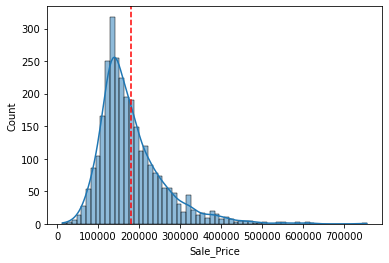

In [27]:
sns.histplot(df['Sale_Price'], kde=True)
plt.axvline(df['Sale_Price'].mean(), ls='--', color='red')

### Ejercicio 4: Importancia relativa
- Implemente la función `plot_importance` utilizado en la lectura para reportar la importancia relativa de los atributos.
- Comente sobre cuáles son los principales 10 atributos que afectan la predicción de `Sale_Price`.
- Separe estos 10 atributos en una nueva base de datos, junto con el vector objetivo.

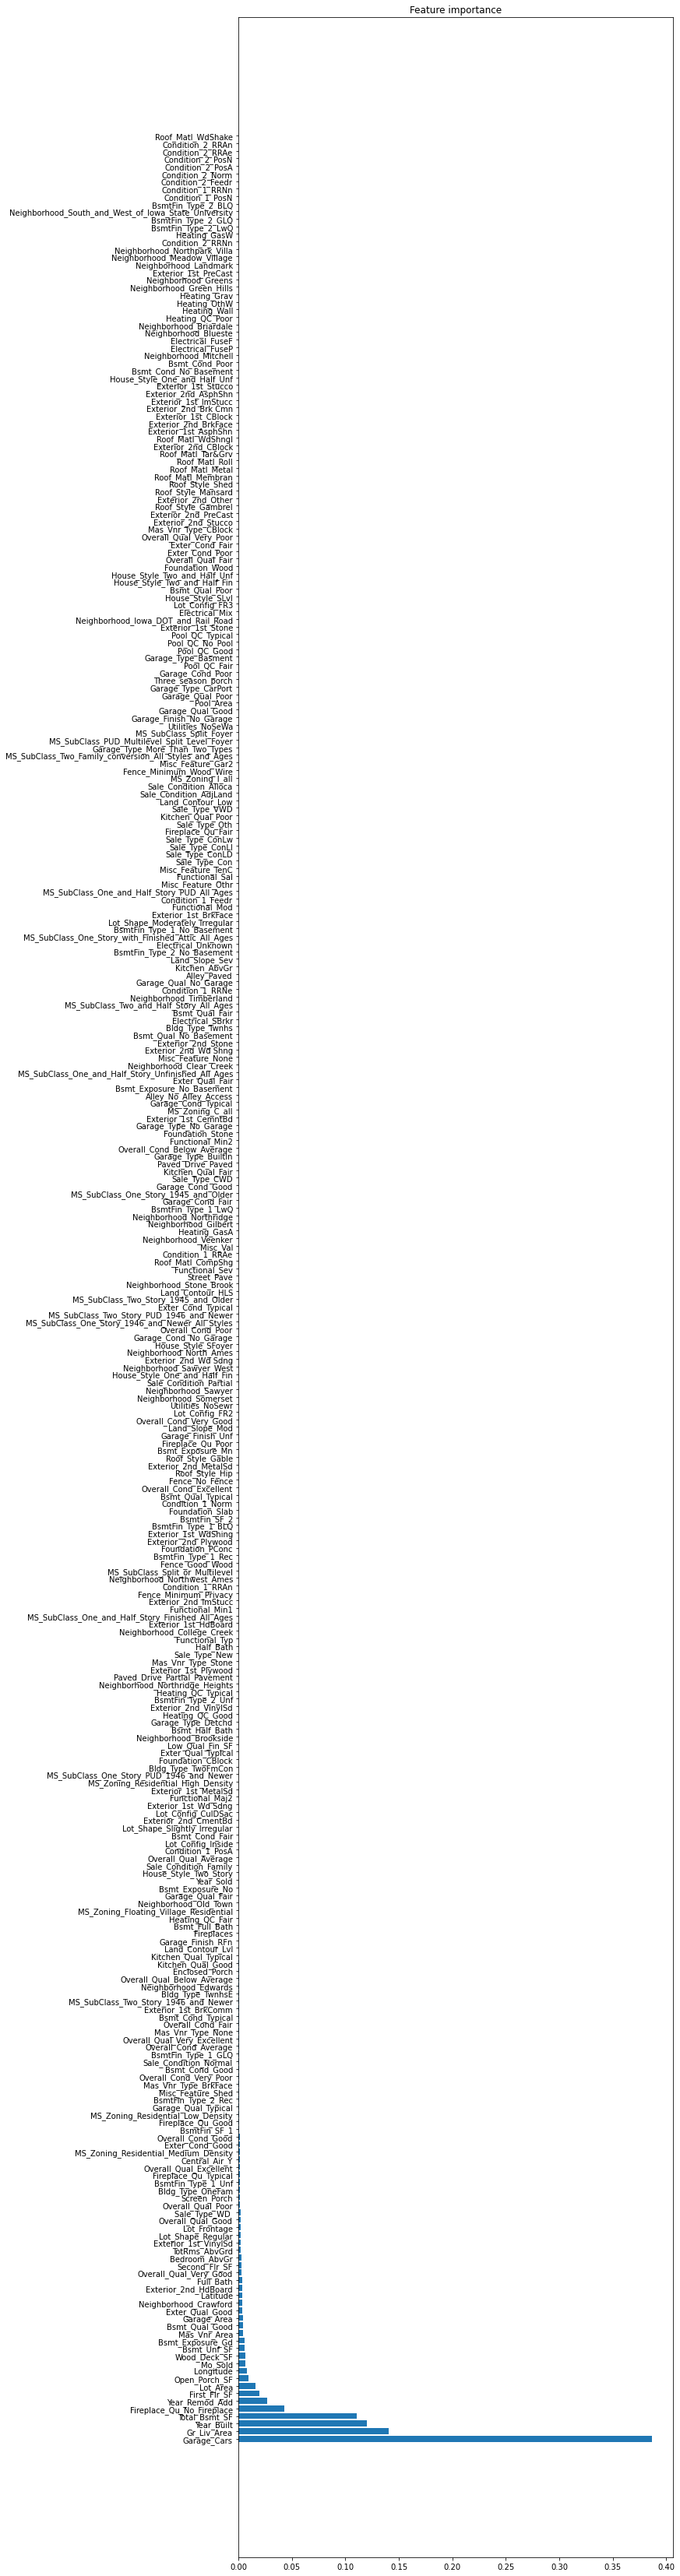

In [28]:
# Utiliza esta celda para definir la función solicitada
plt.figure(figsize=(10,60))
afx.plot_importance(modelo, X_train.columns)

In [29]:
# Utiliza esta celda para realizar el llamado de la función
hold_importance = modelo.feature_importances_
sort_importance = np.argsort(hold_importance)[::-1]

names = [X_train.columns[i] for i in sort_importance][:10]

df_work_10 = df_work[names + ['Sale_Price']]

df_work_10.head()

,Garage_Cars,Gr_Liv_Area,Year_Built,Total_Bsmt_SF,Fireplace_Qu_No_Fireplace,Year_Remod_Add,First_Flr_SF,Lot_Area,Open_Porch_SF,Longitude,Sale_Price
0,2,1656,1960,1080,0,1960,1656,31770,62,-93.619754,215000
1,1,896,1961,882,1,1961,896,11622,0,-93.619756,105000
2,1,1329,1958,1329,1,1958,1329,14267,36,-93.619387,172000
3,2,2110,1968,2110,0,1968,2110,11160,0,-93.617320,244000
4,2,1629,1997,928,0,1998,928,13830,34,-93.638933,189900


### Ejercicio 5: Refactorización del modelo y picklingpd.get_dummies
- En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
- Dentro de los datos de entrenamiento genere una búsqueda de grilla con `GridSearchCV` utilizando los siguientes hiper parámetros:
    - **Máximo de atributos**: Evalúe todos los posibles atributos.
    - **Máximo de profundidad**: Entre 1 a 32.
    - **Validaciones cruzadas**: 5.
- Reporte la mejor combinación de hiper parámetros y su desempeño asociado.
- Compare el desempeño en la muestra de validación con el modelo por defecto.

In [30]:
# Utiliza esta celda para generar los nuevos sets de datos

X = df_work_10.drop(columns='Sale_Price')
y = df_work_10['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [31]:
# Utiliza esta celda para generar y entrenar el objeto GridSearchCV
grilla = GridSearchCV(DecisionTreeRegressor(),
                param_grid = {'max_features': np.linspace(1, X_train.shape[1]),
                        'max_depth': np.linspace(1,32, num=32, endpoint=True).astype(int) }, cv=5)

In [32]:
# Utiliza esta celda para mostrar mejores hiperparámetros y puntaje asociado

grilla.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
                         'max_features': array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])})

In [33]:
# Utiliza esta celda para mostrar las métricas de desempeño
grilla.best_score_

0.7293613566166055

In [34]:
mejor_modelo = grilla.best_estimator_

### Pickling
- Ahora generamos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo `pickle`.
- `pickle` contiene la función `dump`, que permite guardar el modelo desarrollado. 
- La forma canónica para desarrollar el pickling es:
```python
pickle.dump(<OBJETO_CON_EL_MODELO>,open('nombre-apellido-actividad07.sav', 'wb'))
```
- Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [35]:
# Utiliza esta celda para importar pickle y serializar el modelo
pickle.dump(mejor_modelo,open('archivos/model_dms.sav', 'wb'))

### Serialización de datos
- Los `pd.DataFrame` se pueden guardar como archivos csv con el método `.to_csv('nombre_archivo.csv', index=False)`
- El parámetro `index=False` evita que se genere la columna `Unnamed: 0`

In [36]:
# Utiliza esta celda para guardar archivos csv de las muestras generadas con train test split para el último modelo
X_train.to_csv('archivos/X_train.csv', index = False)
X_test.to_csv('archivos/X_test.csv', index = False)

In [37]:
X_train.head()

,Garage_Cars,Gr_Liv_Area,Year_Built,Total_Bsmt_SF,Fireplace_Qu_No_Fireplace,Year_Remod_Add,First_Flr_SF,Lot_Area,Open_Porch_SF,Longitude
987,2,1567,1977,1567,0,1977,1567,9819,32,-93.599866
1854,2,2362,1980,2002,0,1980,2362,12000,16,-93.645798
1821,1,999,1962,999,1,2001,999,7758,132,-93.673889
2183,1,960,1959,960,1,2000,960,6400,0,-93.665737
2194,0,3395,1914,1440,1,1995,1440,10896,110,-93.650162


In [38]:
pd_out_test = pd.read_csv('archivos/X_test.csv')
pd_out_train = pd.read_csv('archivos/X_train.csv')

In [39]:
pd_out_test.sample(6, random_state = 15820)

,Garage_Cars,Gr_Liv_Area,Year_Built,Total_Bsmt_SF,Fireplace_Qu_No_Fireplace,Year_Remod_Add,First_Flr_SF,Lot_Area,Open_Porch_SF,Longitude
652,1,1012,1920,1012,0,1950,1012,8263,22,-93.629496
646,1,1268,1977,1268,1,1989,1268,9286,0,-93.684954
48,2,960,1955,960,1,1955,960,6000,0,-93.607862
406,1,874,1968,864,1,1968,874,9858,0,-93.604218
785,2,1177,1984,1153,1,1984,1177,11850,103,-93.631795
520,0,974,1991,974,1,1992,974,10712,28,-93.606641


In [40]:
pd_out_train.sample(6, random_state = 15820)

,Garage_Cars,Gr_Liv_Area,Year_Built,Total_Bsmt_SF,Fireplace_Qu_No_Fireplace,Year_Remod_Add,First_Flr_SF,Lot_Area,Open_Porch_SF,Longitude
394,2,1040,1950,0,1,1950,1040,7200,0,-93.608903
73,2,1005,1955,1005,0,1955,1005,10434,0,-93.612400
105,1,1152,1978,1152,1,1978,1152,10547,0,-93.657107
632,1,1055,1978,1061,1,1978,1055,2304,32,-93.625672
1666,2,1116,1974,1116,0,1974,1116,10140,0,-93.632178
807,2,1820,1965,864,0,1988,902,13700,84,-93.616700
